Imports

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

import os

Dataset Configuration

In [2]:
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Train',
    image_size=(128,128),
    batch_size=batch_size,
    label_mode = 'categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd() + '/Test',
    image_size=(128,128),
    batch_size=batch_size,
    label_mode = 'categorical'
)

Found 660 files belonging to 7 classes.
Found 207 files belonging to 7 classes.


In [3]:
num_classes = len(train_ds.class_names)


Dataset Visualization

['Coffee', 'Corn', 'Eucalyptus', 'Goiaba', 'Orange', 'Soybean', 'Tomato']


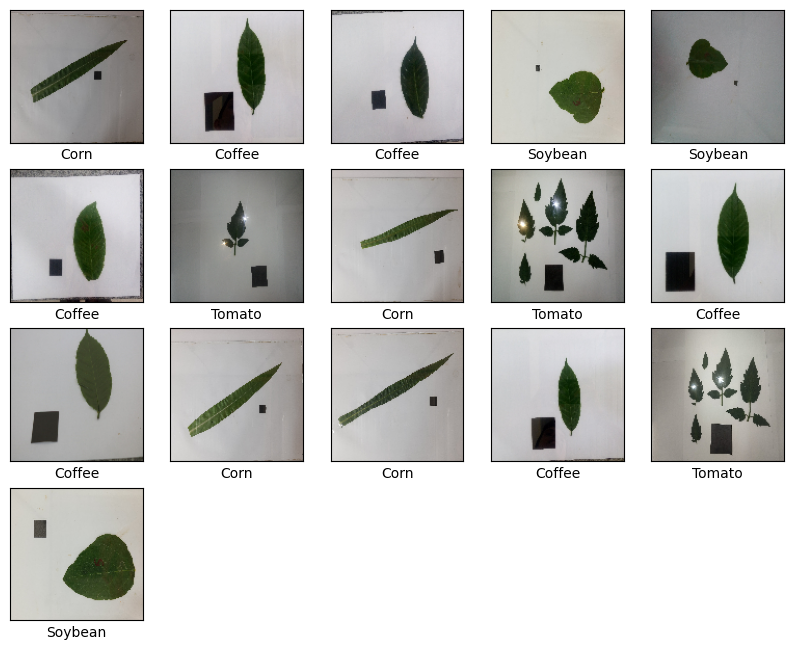

In [4]:
class_names = train_ds.class_names

print(class_names)

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(16):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.xlabel(class_names[tf.math.argmax(labels[i])])
  plt.show()

Normalizing Dataset

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Model

In [35]:
image_shape = (128, 128, 3)
# image_shape = (1920, 2560, 3)

# # LeNet-5
# model = Sequential([
#             Conv2D(6, 5, activation='relu', input_shape=image_shape),
#             MaxPooling2D(strides=(2,2)),
#             Conv2D(16, 5, activation='relu'),
#             MaxPooling2D(strides=(2,2)),
#             Flatten(),
#             Dense(120, activation='relu'),
#             Dropout(0.5),
#             Dense(84, activation='relu'),
#             Dropout(0.5),
#             Dense(7, activation='softmax')
# ])

# AlexNet
model = Sequential([
            Conv2D(96, 11, strides=(4,4), activation='relu', input_shape=image_shape),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(256, 5, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(384, 3, padding='same', activation='relu'),
            Conv2D(384, 3, padding='same', activation='relu'),
            Conv2D(256, 3, padding='same', activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(4096, activation='relu'),
            Dropout(0.5),
            Dense(7, activation='softmax')
])

# # VGG-16
# model = Sequential([
#             Conv2D(64, 3, padding='same', activation='relu', input_shape=image_shape),
#             Conv2D(64, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(128, 3, padding='same', activation='relu'),
#             Conv2D(128, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             Conv2D(512, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(2,2), strides=(2,2)),
#             Flatten(),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(7, activation='softmax')
# ])

# # Inception
# model = Sequential([
#             Conv2D(64, 7, strides=(2,2), padding='same', activation='relu', input_shape=image_shape),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(64, 1, activation='relu'),
#             Conv2D(192, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(64, 1, activation='relu'),
#             Conv2D(128, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(128, 1, activation='relu'),
#             Conv2D(192, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Conv2D(256, 1, activation='relu'),
#             Conv2D(384, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             Conv2D(256, 3, padding='same', activation='relu'),
#             MaxPooling2D(pool_size=(3,3), strides=(2,2)),
#             Flatten(),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(4096, activation='relu'),
#             Dropout(0.5),
#             Dense(7, activation='softmax')
# ])


model.compile(optimizer=SGD(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

c:\Users\joaov\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │        28,679 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,755,591 (94.44 MB)

 Trainable params: 24,755,591 (94.44 MB)

 Non-trainable params: 0 (0.00 B)

TRAINING

In [36]:
history = model.fit(train_ds, epochs=18)

train_acc = history.history["accuracy"]
train_loss = history.history["loss"]


Epoch 1/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.1523 - loss: 5.1179
Epoch 2/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.2042 - loss: 1.8848
Epoch 3/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.1951 - loss: 1.8966
Epoch 4/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.2007 - loss: 1.8555
Epoch 5/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.2329 - loss: 1.8496
Epoch 6/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.2391 - loss: 1.8282
Epoch 7/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.2366 - loss: 1.8031
Epoch 8/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.3117 - loss: 1.7396
Epoch 9/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.2907 - loss: 1.7378
Epoch 10/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.3378 - loss: 1.6310
Epoch 11/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.3719 - loss: 1.6471
Epoch 12/18
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step

Testing

In [37]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

print('\nTest accuracy:', test_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5570 - loss: 1.1110

Test accuracy: 0.5169082283973694


Plotting

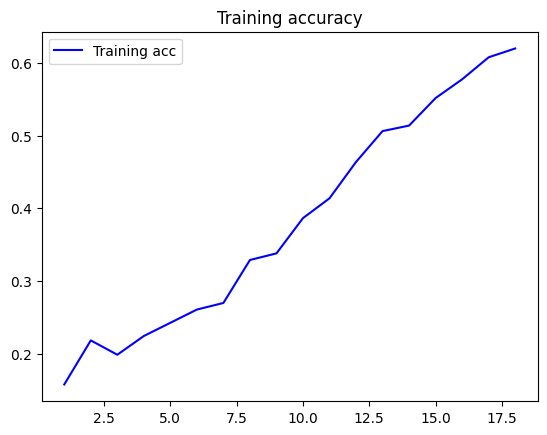

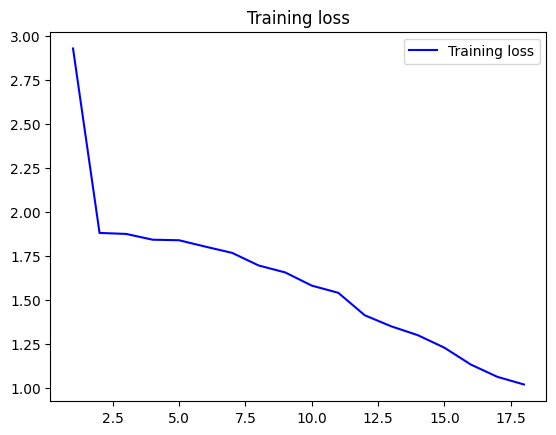

In [38]:
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [61]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_ds)


# # confusion matrix
# confusion_matrix = metrics.confusion_matrix(test_ds, np.argmax(predictions, axis=1))

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=class_names).plot(cmap=plt.cm.Blues)
# plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
[[0.13763878 0.12529892 0.13562241 ... 0.13648915 0.21347257 0.12643428]
 [0.15171337 0.12209991 0.12924632 ... 0.12955707 0.21694955 0.12417195]
 [0.14927238 0.12389909 0.144918   ... 0.1385767  0.19248214 0.12793246]
 ...
 [0.11473848 0.31141567 0.11486052 ... 0.11474182 0.11476597 0.11474085]
 [0.1327071  0.12429119 0.17120238 ... 0.13283621 0.19252616 0.12397148]
 [0.11891858 0.11895216 0.11960176 ... 0.11944699 0.1410421  0.26354483]]
